<a href="https://colab.research.google.com/github/1eetnals/Mary-s-Hospital-AI-center/blob/main/fracture%2C_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 19.3MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 47.3MB/s 
     |████████████████████████████████| 194kB 61.1MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
xray_types = 'normal','fracture'
path = Path('/content/gdrive/MyDrive/train')
print(path)

/content/gdrive/MyDrive/train


In [ ]:
prac = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(248))

In [ ]:
dls = prac.dataloaders(path)

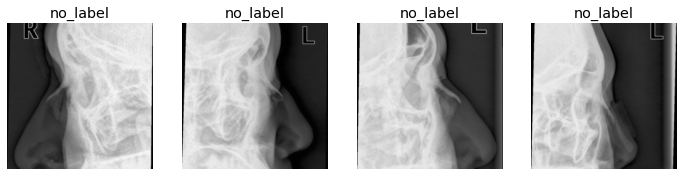

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
prac = prac.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms(mult=2))
dls = prac.dataloaders(path)

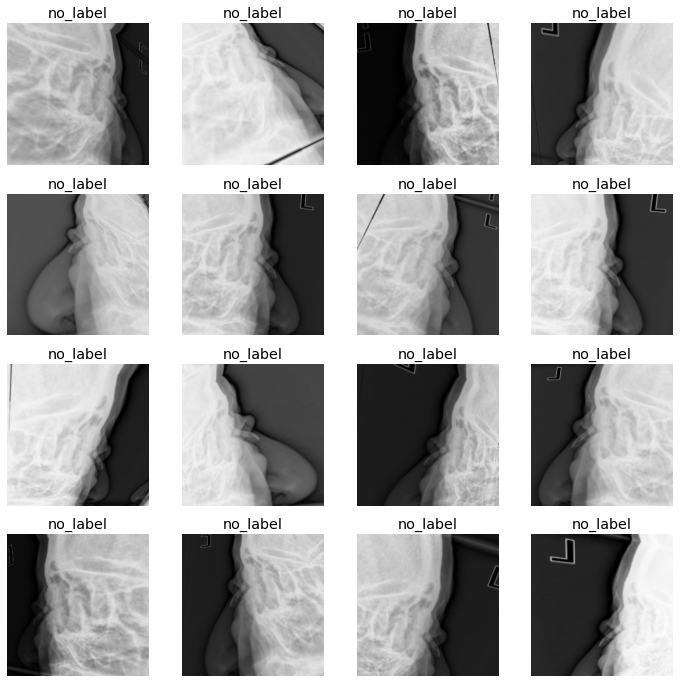

In [ ]:
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.749488,0.309192,0.111486,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.679985,0.329180,0.118243,00:13
1,0.629729,0.377272,0.128378,00:13
2,0.575036,0.264157,0.047297,00:13
3,0.541532,0.249795,0.074324,00:13
4,0.495133,0.196044,0.040541,00:13
5,0.450031,0.183215,0.047297,00:14
6,0.415456,0.142959,0.020270,00:13
7,0.387551,0.134531,0.013514,00:13


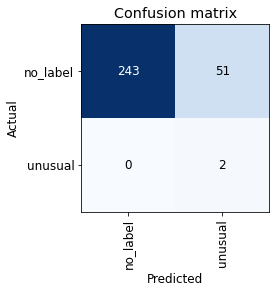

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

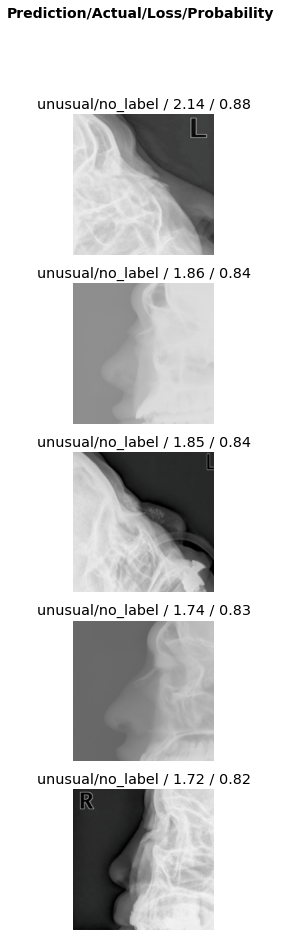

In [ ]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
class Hook():
   def __init__(self, m):
     self.hook = m.register_forward_hook(self.hook_func)
     def hook_func(self, m, i, o): self.stored = o.detach().clone()
     def __enter__(self, *args): return self
     def __exit__(self, *args): self.hook.remove()
     class HookBwd():
       def __init__(self, m):
         self.hook = m.register_backward_hook(self.hook_func)
         def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
         def __enter__(self, *args): return self
         def __exit__(self, *args): self.hook.remove()

In [ ]:
import os
import pandas as pd
path0 = '/content/gdrive/MyDrive/train/'
fnames = os.listdir(path0)
path0
len(fnames)

2

In [ ]:
fn= 0
imgpath = path0 + fnames[fn]
img = PILImage.create(imgpath)
x, = first(dls.test_dl([img]))
a,b,pred = learn.predict(img)

if pred[0]>.5:
  cls = 0
else:
  cls = 1

with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0,cls].backward()
  grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

In [ ]:
plt.figure(dpi=256)
plt.subplot(121)
plt.imshow(x_dec[0].detach().cpu(), alpha=1, extent=(0,512,512,0),interpolation='bicubic', cmap='gray')
plt.axis('off')
plt.title(fnames[fn],fontsize=10)
plt.subplot(122)
plt.imshow(x_dec[0].detach().cpu(), alpha=1, extent=(0,512,512,0), interpolation='bicubic', cmap='gray')
plt.imshow(cam_map.detach().cpu(), alpha=0.42, extent=(0,512,512,0), interpolation='bicubic', cmap='magma')
plt.axis('off')
plt.title(f'{a}: {pred[0]}',fontsize=10)
plt.show()